# Graph Neural Network pada Jaringan Klub Karate

In [216]:
!pip install dgl

You should consider upgrading via the 'c:\users\ilma aliya fiddien\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [247]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import requests
import itertools

import torch
from torch import nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

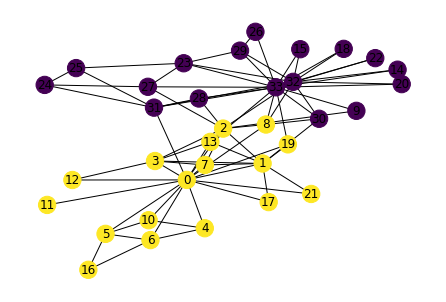

In [218]:
# membuka jaringan karate club
G = nx.karate_club_graph()

# one hot encoding untuk klub
club = [G.nodes[v]['club']=='Mr. Hi' for v in G.nodes]

# tampilkan jaringan
nx.draw(G, node_color=club, with_labels=True)

In [219]:
# cek derajat tiap simpul
print("Simpul Derajat   Club")
for v in G:
    print(f"{v:3}     {G.degree(v):3}     {G.nodes[v]['club']}")

Simpul Derajat   Club
  0      16     Mr. Hi
  1       9     Mr. Hi
  2      10     Mr. Hi
  3       6     Mr. Hi
  4       3     Mr. Hi
  5       4     Mr. Hi
  6       4     Mr. Hi
  7       4     Mr. Hi
  8       5     Mr. Hi
  9       2     Officer
 10       3     Mr. Hi
 11       1     Mr. Hi
 12       2     Mr. Hi
 13       5     Mr. Hi
 14       2     Officer
 15       2     Officer
 16       2     Mr. Hi
 17       2     Mr. Hi
 18       2     Officer
 19       3     Mr. Hi
 20       2     Officer
 21       2     Mr. Hi
 22       2     Officer
 23       5     Officer
 24       3     Officer
 25       3     Officer
 26       2     Officer
 27       4     Officer
 28       3     Officer
 29       4     Officer
 30       4     Officer
 31       6     Officer
 32      12     Officer
 33      17     Officer


## Sisi

Data original diperoleh dari: http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm#zachary

In [220]:
# get the original data
url = "http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/zachary.dat"
dat = requests.get(url).text

# take adjecency matrix for the .dat file
adj_matrices = dat.split("\r\n ")[1:]
adj_matrices = np.array(np.array([row.split(' ') for row in adj_matrices], dtype='int'))

# graph with unweighted edges
zache = adj_matrices[:34]

# graph with weighted edges
zachc = adj_matrices[34:]

G_ = nx.from_numpy_matrix(zache)
Gw = nx.from_numpy_matrix(zachc)

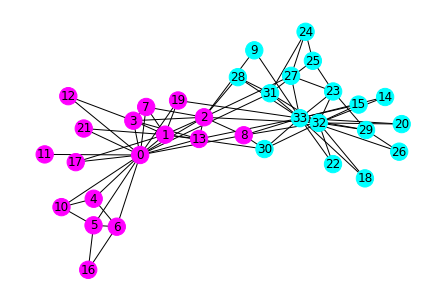

In [262]:
# mengambil dari Gw dan memasukkan atribut weigths ke G
weights = nx.get_edge_attributes(Gw, 'weight')
nx.set_edge_attributes(G, weights, 'weight')
widths = [weights[w] for w in weights]

pos = nx.spring_layout(G)
nx.draw(G_, pos, with_labels=True, node_color=club, cmap='cool')

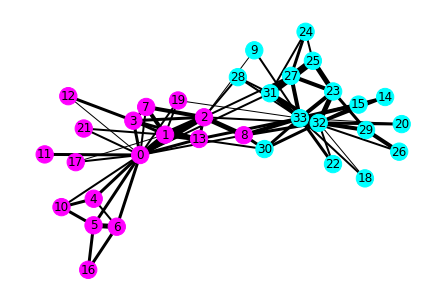

In [264]:
# tampilkan dengan weights sisi sebagai ketebalan sisi
nx.draw(Gw, pos, with_labels=True, node_color=club, width=widths, cmap='cool')

## GNN Model

### Definisikan dataset

Definisikan input

In [275]:
# gunakan fitur klub
club = torch.tensor(clubs).long()
# aplikasikan one-hot encoding
club_one_hot = F.one_hot(club)
# gunakan fitur weight
weight = torch.tensor(widths)

# 
g = dgl.from_networkx(Gw)
g.ndata.update({'club': club, 'club_one_hot': club_one_hot})
g.edata.update({'weight': weight})
g

DGLError: Expect number of features to match number of edges. Got 78 and 156 instead.

In [276]:
widths

[4,
 5,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 1,
 3,
 2,
 2,
 2,
 2,
 6,
 3,
 4,
 5,
 1,
 2,
 2,
 2,
 3,
 4,
 5,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 5,
 3,
 3,
 3,
 3,
 3,
 4,
 2,
 3,
 3,
 2,
 3,
 4,
 1,
 2,
 1,
 3,
 1,
 2,
 3,
 5,
 4,
 3,
 5,
 4,
 2,
 3,
 2,
 7,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 3,
 3,
 4,
 4,
 5]

In [238]:
# Setiap simpul memiliki embedding berukuran 5
node_embed = nn.Embedding(G.order(), 5)

# gunakan weight node embedding sebagai input model
input = node_embed.weight

# aplikasikan xavier uniform pada `input`
nn.init.xavier_uniform_(input)

Parameter containing:
tensor([[-0.1154, -0.1028, -0.3361, -0.0402,  0.1112],
        [-0.0903, -0.2497,  0.2642, -0.1675,  0.1663],
        [-0.0922, -0.1618,  0.0561, -0.2091,  0.2459],
        [ 0.1921,  0.2213,  0.2846, -0.0970, -0.1070],
        [-0.3719,  0.3588, -0.2812, -0.0902,  0.0385],
        [-0.3345,  0.1736,  0.1378, -0.1602, -0.3324],
        [ 0.2596,  0.1127,  0.1853, -0.1231, -0.0823],
        [-0.0180, -0.3372, -0.2020, -0.2496,  0.3277],
        [-0.2153, -0.3127, -0.3817,  0.1717,  0.3251],
        [ 0.3792, -0.0979, -0.3658,  0.2925, -0.2547],
        [-0.0277,  0.3253,  0.0854, -0.0256,  0.1671],
        [-0.1809,  0.0406,  0.3608,  0.2509,  0.0085],
        [-0.2712,  0.0986, -0.0932, -0.2152,  0.0457],
        [ 0.1624,  0.2240,  0.3631, -0.0685, -0.2552],
        [ 0.0421, -0.3686, -0.1384, -0.2635,  0.1721],
        [-0.3405, -0.2482,  0.1145,  0.2472, -0.2226],
        [-0.1750, -0.2139, -0.3733,  0.3378,  0.1683],
        [ 0.0769,  0.1552, -0.0518, -0.0622

Definisikan output/label

In [236]:
# mengubah `clubs` menjadi tensor
label = torch.tensor(clubs).long()

# aplikasikan one-hot encoding
label = F.one_hot(label)

# fitur label untuk simpul dua kepala klub: 0 dan 33
labeled_nodes = [0, 33]

Definisikan graf ke dalam tipe data graf dgl

### Definisikan model

Kita akan membangun model baru di atas model *SAGEConv* dari library *dgl*.

In [241]:
class GraphSAGE(nn.Module):
    def __init__(self, input_features, hidden_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_features, hidden_features, 'mean')
        self.conv2 = SAGEConv(hidden_features, num_classes, 'mean')
        
    def forward(self, graph, input_features):
        result = self.conv1(graph, input_features)
        result = F.relu(result)
        result = self.conv2(graph, result)
        return result
    
# Buat model dengan dimensi berikut
# input layer  : 5, node embeddings
# hidden layer : 16
# output layer : 2, dua kelas
model = GraphSAGE(5, 16, 2)

In [252]:
# definisikan optimizer
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), node_embed.parameters()), 
    lr=0.01)

### Latih model

In [254]:
all_logits = []

for epoch in range(100):
    # forward pass
    logits = model(G, input)
    
    # hitung loss
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    all_logits.append(logits.detach())
    if epoch%5==0:
        print(f"Epoch {epoch:3}, loss {loss:6}")

AttributeError: 'Graph' object has no attribute 'local_scope'